In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

2025-06-27 22:14:34.447032: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 22:14:34.449579: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 22:14:34.456351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751080474.466883  972484 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751080474.470001  972484 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751080474.479178  972484 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Data Ingestion

## Load dataset training
### Memory optimization when loading the dataset

Since the dataset is very large, memory usage will be optimized when reading it with Pandas. By default, Pandas allocates data types like `int64`, `float64` or `object`, which can be unnecessarily heavy.

To reduce memory consumption:

- Numeric columns are **downcasted** to smaller types such as `int32`, `int8` or `float32`, whenever the range of values allows it.
- Categorical columns that Pandas would detect as `object` are forced to `category`, significantly reducing their size.

To apply this optimization, a **type dictionary (`dtype`)** will be used when reading the CSV with `pandas.read_csv`, specifying the type of each column.


In [2]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


## Load Labels
Load `train_labels.csv`, which contains for each session an indicator of whether the user answered each question correctly.  
These values constitute the **target variable** (or **labels/targets**) that the model must predict.


In [3]:
labels = pd.read_csv('train_labels.csv')
labels.head(5)

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


The session id column contains both the session id and the question, marked by a q and the number. Let's split this column in two and add them to the dataframe.

In [4]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [5]:
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


## Display answers to each question

First, the number of correct and incorrect answers will be plotted.

<Axes: xlabel='correct'>

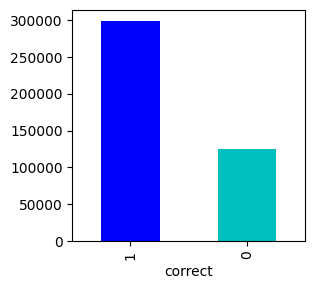

In [24]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

Subsequently, a graph will be made for each question, showing how many people answered correctly and how many did not.

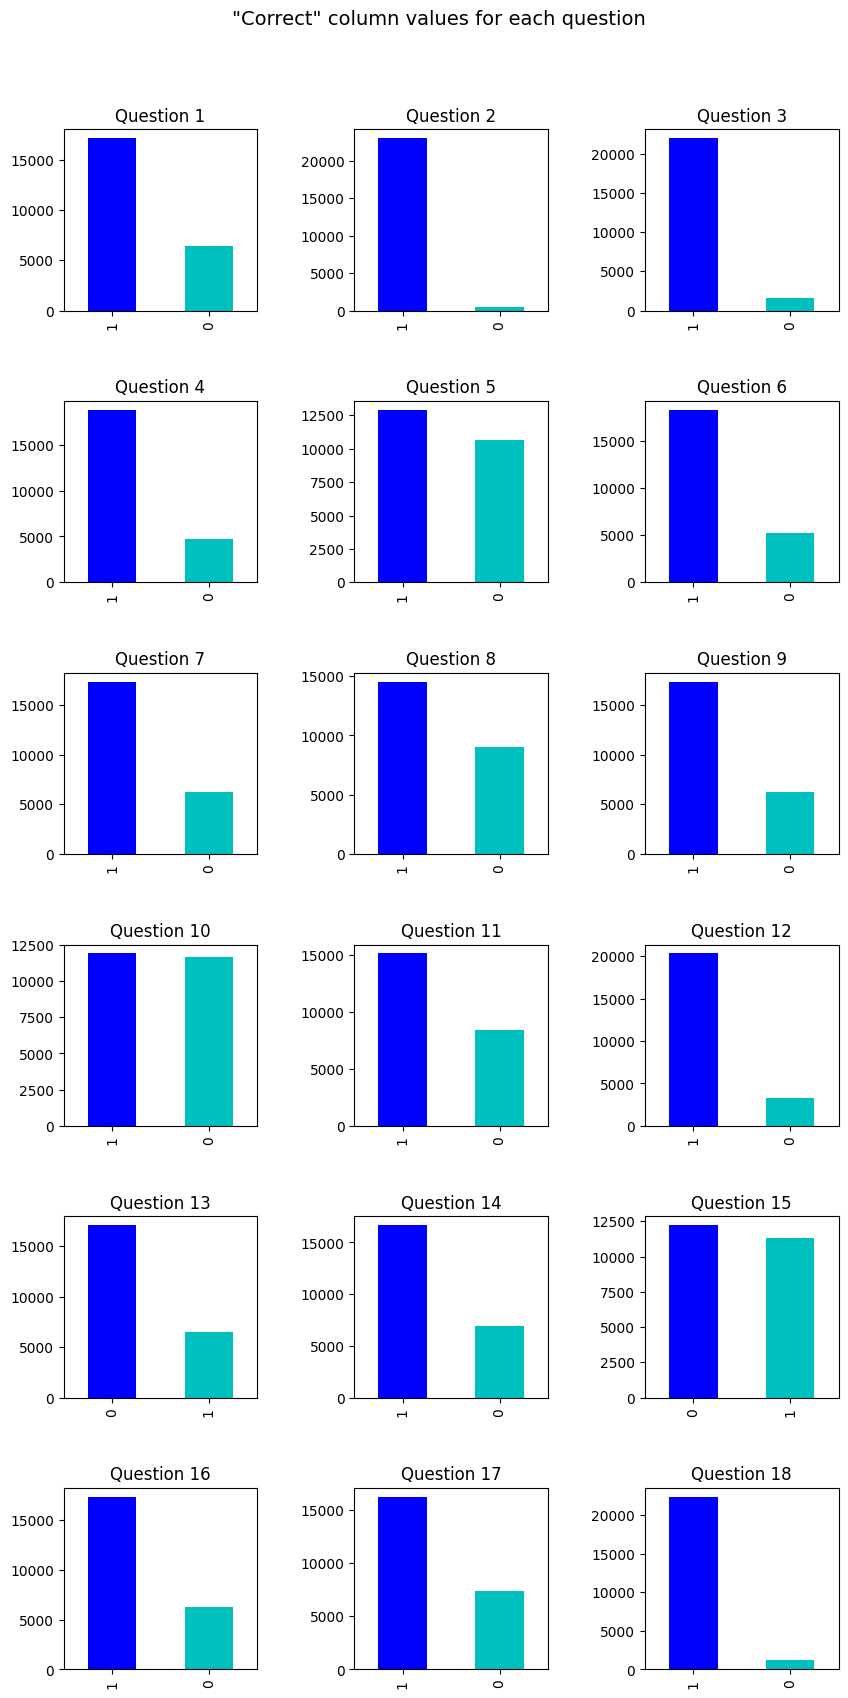

In [25]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)

for n in range(1,19):
    ax = plt.subplot(6, 3, n)

    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(kind="bar", color=['b', 'c'])

    ax.set_title("Question " + str(n))
    ax.set_xlabel("")

# Data Preparation

## Feature Engineering Setup

The dataset organizes user interactions into segments using the `level_group` column, which divides levels into three groups: `0-4`, `5-12`, and `13-22`.

Our objective is to predict whether each user answered each question in these level groups correctly.

To facilitate feature engineering, we define a dictionary called `FEATURE_SETS`. This dictionary includes multiple sets of features, where each set specifies:

- A list of **categorical columns** (used for frequency or uniqueness aggregations).
- A list of **numerical columns** (used for computing mean and standard deviation).
- A short **description** of the feature set’s focus.

These predefined feature set help us explore different modeling strategies based on various aspects of user interaction, such as interface configuration, text interaction, or screen behavior.

In [6]:
FEATURE_SETS = {
    1: {
        'categorical': ['event_name', 'name', 'fqid'],
        'numerical': ['elapsed_time', 'hover_duration', 'room_coor_x', 'room_coor_y'],
        'description': "Basic set with main user interactions"
    },
    2: {
        'categorical': ['fullscreen', 'hq', 'music', 'room_fqid'],
        'numerical': ['screen_coor_x', 'screen_coor_y', 'elapsed_time'],
        'description': "Set focused on user configuration settings"
    },
    3: {
        'categorical': ['event_name', 'fqid'],
        'numerical': ['elapsed_time'],
        'description': "Minimal set with only event-based features"
    },
    4: {
        'categorical': ['text', 'text_fqid'],
        'numerical': ['screen_coor_x', 'screen_coor_y', 'hover_duration'],
        'description': "Set focused on textual interaction features"
    }
}

### Function: `feature_engineer`

The `feature_engineer` function creates aggregated features from an interaction dataset grouped by `session_id` and `level_group`. For each categorical column provided, it calculates the number of unique values within each group. For each numerical column, it computes both the mean and standard deviation. These results are combined into a single DataFrame. Missing values are filled with -1, and the final dataset is indexed by `session_id`. The output is a feature-enriched dataset ready for modeling tasks.


We also split the dataset into a training dataset and a test dataset.

In [7]:
from Modules.DataPreparation import feature_engineer, split_dataset

def prepare_all_datasets(dataset_df, feature_sets):
    datasets = {}
    train_x_sets = {}
    valid_x_sets = {}
    
    for set_id, features in feature_sets.items():
        try:
            missing_cols = [col for col in features['categorical'] + features['numerical'] 
                            if col not in dataset_df.columns]
            
            if missing_cols:
                print(f"Warning: Set {set_id} - Missing columns: {missing_cols}")
                continue
                
            # Data processing
            processed_data = feature_engineer(
                dataset_df, 
                features['categorical'],
                features['numerical']
            )
            
            train_x, valid_x = split_dataset(processed_data)
            
            # Store results
            datasets[set_id] = {
                'features': features,
                'processed_data': processed_data
            }
            train_x_sets[set_id] = train_x
            valid_x_sets[set_id] = valid_x
            
            print(f"Set {set_id} prepared: {features['description']}")
            
        except Exception as e:
            print(f"Error processing set {set_id}: {str(e)}")
    
    return datasets, train_x_sets, valid_x_sets

datasets, train_x_sets, valid_x_sets = prepare_all_datasets(dataset_df, FEATURE_SETS)

Set 1 prepared: Basic set with main user interactions
Set 2 prepared: Set focused on user configuration settings
Set 3 prepared: Minimal set with only event-based features
Set 4 prepared: Set focused on textual interaction features


In [9]:
# Display the first 5 examples
set_id = 1
dataset_df = pd.DataFrame(datasets[set_id]['processed_data'])
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,elapsed_time,hover_duration,room_coor_x,room_coor_y,elapsed_time_std,hover_duration_std,room_coor_x_std,room_coor_y_std
session_id,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,8.579356e+04,2389.500000,7.701275,-71.413750,49246.539458,3227.370757,399.296051,129.292404
20090312431273200,13-22,10,3,49,1.040601e+06,899.925903,-130.347168,-162.004303,126666.129584,1305.088265,622.061401,230.370880
20090312431273200,5-12,10,3,39,3.572052e+05,969.333313,14.306062,-57.269321,80175.676658,1316.408315,357.227692,137.409470
20090312433251036,0-4,11,4,22,9.763342e+04,1378.750000,-84.045959,-53.671082,67372.714092,2114.876406,445.980042,156.186249
20090312433251036,13-22,11,6,73,2.498852e+06,720.384949,-30.762283,-142.861893,777382.529186,1990.705518,529.575684,234.279587


Let us plot some numerical columns and their value against each level_group:

/tmp/ipykernel_972484/4072932276.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, data in dataset_df.groupby('level_group'):


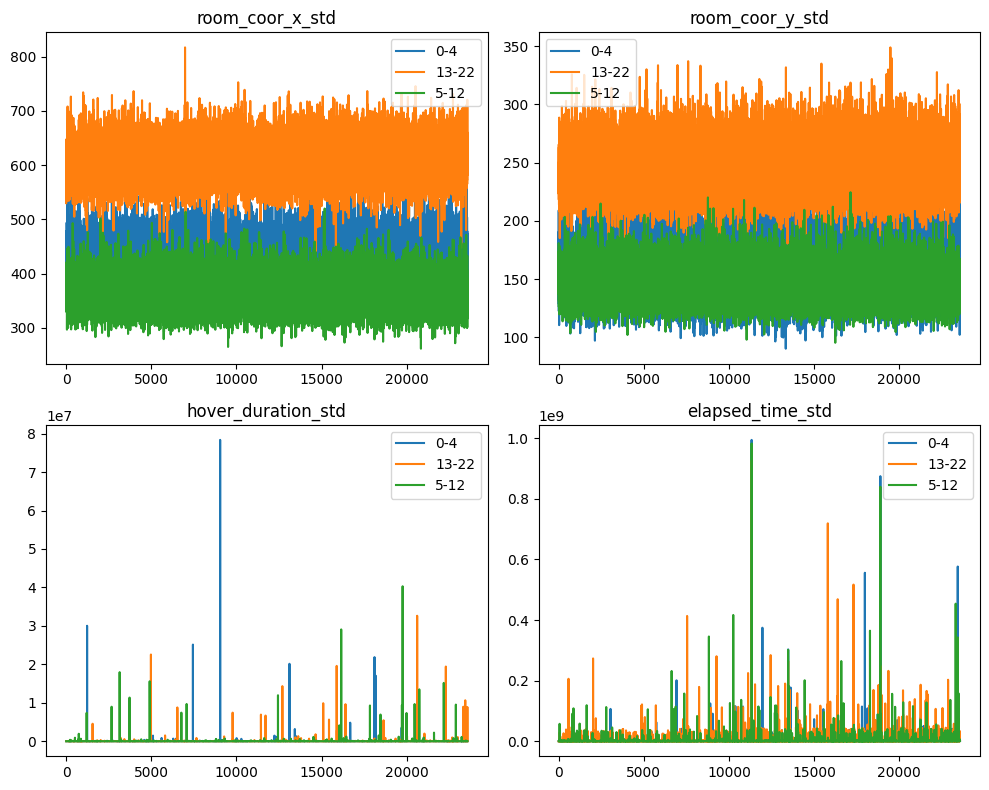

In [10]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(2, 2, figsize=(10, 8))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['hover_duration_std'])+1), data['hover_duration_std'], label=name)
    axis[1, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)


axis[0, 0].set_title('room_coor_x_std')
axis[0, 1].set_title('room_coor_y_std')
axis[1, 0].set_title('hover_duration_std')
axis[1, 1].set_title('elapsed_time_std')


for i in range(2):
    for j in range(2):
        axis[i, j].legend()

plt.tight_layout()  
plt.show()

# Select Model
We will use two tree-based machine learning models: Random Forest and XGBoost.



## Training
A model will be trained for each question in order to know if it will be answered correctly by a user. Each question will be modeled using the two aforementioned algorithms, combined with the four different feature sets. This results in a total of 8 evaluation metrics per question—one for each model-feature set combination.


### Understanding the Mapping Between Level Groups and Questions

Before training the models, it's important to clarify how quiz questions relate to level groups.

In the game, each `level_group` is followed by one or more quiz questions that assess user performance on that group of levels. The mapping is as follows:

- Questions 1 to 3 are based on interactions within level group 0–4
- Questions 4 to 13 correspond to level group 5–12
- Questions 14 to 18 correspond to level group 13–22

When training a model for a specific question, only the session data from its corresponding level group is used.

A separate model is trained for each question, and all models are stored in the `models` dictionary.



In [12]:

from Modules.Models import XGBoostModel,ModelML,RandomForestTreeModel

def train_all_models(train_x_sets, valid_x_sets, labels):
    results = {}
    
    for set_id, train_x in train_x_sets.items():
        # Entrenar Random Forest
        rf_model = RandomForestTreeModel(valid_x_sets[set_id].index.unique())
        rf_models, rf_metrics = rf_model.train(train_x, valid_x_sets[set_id], labels)
        
        # Entrenar XGBoost
        xgb_model = XGBoostModel(valid_x_sets[set_id].index.unique())
        xgb_models, xgb_metrics = xgb_model.train(train_x, valid_x_sets[set_id], labels)
        
        results[set_id] = {
            'random_forest': {
                'models': rf_models,
                'metrics': rf_metrics
            },
            'xgboost': {
                'models': xgb_models,
                'metrics': xgb_metrics
            },
            'features': FEATURE_SETS[set_id]
        }
        
    
    return results

results = train_all_models(train_x_sets,valid_x_sets,labels)

Use /tmp/tmp1wnl1g6v as temporary training directory


E0000 00:00:1751080606.494516  972484 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751080606.495052  972484 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
W0000 00:00:1751080606.540507  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080606.540529  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080608.492827  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:0

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080609.579736  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080609.579755  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080609.722376  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080609.722395  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080609.722400  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080609.722459  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080609.722463  9

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080609.988222  974291 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.18591
I0000 00:00:1751080609.988244  974291 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 61
I0000 00:00:1751080609.989572  974291 gradient_boosted_trees.cc:279] Truncates the model to 32 tree(s) i.e. 32  iteration(s).
I0000 00:00:1751080609.989673  974291 gradient_boosted_trees.cc:341] Final model num-trees:32 valid-loss:0.185910 valid-accuracy:0.981112
I0000 00:00:1751080609.990064  974291 kernel.cc:926] Export model in log directory: /tmp/tmpx9kzd894 with prefix dc890a93d8c94816
I0000 00:00:1751080609.990878  974291 kernel.cc:944] Save model in resources
I0000 00:00:1751080609.991852  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.18591

Accuracy: 0.981112  CI95[W][0 1]
ErrorRate: : 0.0188883


Confusion Table:
truth

5/5 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9353


5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080610.826979  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080610.826996  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080610.977621  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080610.977641  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080610.977646  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080610.977702  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080610.977707  9

5/5 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.7929


I0000 00:00:1751080611.281101  976286 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.95884
I0000 00:00:1751080611.281124  976286 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 68
I0000 00:00:1751080611.282654  976286 gradient_boosted_trees.cc:279] Truncates the model to 39 tree(s) i.e. 39  iteration(s).
I0000 00:00:1751080611.282740  976286 gradient_boosted_trees.cc:341] Final model num-trees:39 valid-loss:0.958840 valid-accuracy:0.799784
I0000 00:00:1751080611.283133  976286 kernel.cc:926] Export model in log directory: /tmp/tmpi5xxhato with prefix 531ca8fc2daf4599
I0000 00:00:1751080611.283968  976286 kernel.cc:944] Save model in resources
I0000 00:00:1751080611.284909  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.95884

Accuracy: 0.799784  CI95[W][0 1]
ErrorRate: : 0.200216


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080611.479762  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080611.479780  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


I0000 00:00:1751080611.628177  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080611.628199  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080611.628203  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080611.628257  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080611.628262  972484 kernel.cc:402] Number of examples: 18849
I0000 00:00:1751080611.629670  972484 kernel.cc:802] Training dataset:
Number of records: 18849
Number of columns: 12

Number of columns by type:
	NUMERICAL: 11 (91.6667%)
	CATEGORICAL: 1 (8.33333%)

Columns:

NUMERICAL: 11 (91.6667%)
	1: "elapsed_time" NUME

I0000 00:00:1751080611.996222  977528 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.31513
I0000 00:00:1751080611.996245  977528 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 77
I0000 00:00:1751080611.998248  977528 gradient_boosted_trees.cc:279] Truncates the model to 48 tree(s) i.e. 48  iteration(s).
I0000 00:00:1751080611.998351  977528 gradient_boosted_trees.cc:341] Final model num-trees:48 valid-loss:1.315132 valid-accuracy:0.621695
I0000 00:00:1751080611.998770  977528 kernel.cc:926] Export model in log directory: /tmp/tmp2hgxesod with prefix 919d902ef33446c9
I0000 00:00:1751080611.999650  977528 kernel.cc:944] Save model in resources
I0000 00:00:1751080612.000657  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.31513

Accuracy: 0.621695  CI95[W][0 1]
ErrorRate: : 0.378305


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080612.201781  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080612.201800  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


I0000 00:00:1751080612.504398  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080612.504425  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080612.504431  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080612.504488  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080612.504493  972484 kernel.cc:402] Number of examples: 18849
I0000 00:00:1751080612.505659  972484 kernel.cc:802] Training dataset:
Number of records: 18849
Number of columns: 12

Number of columns by type:
	NUMERICAL: 11 (91.6667%)
	CATEGORICAL: 1 (8.33333%)

Columns:

NUMERICAL: 11 (91.6667%)
	1: "elapsed_time" NUME

I0000 00:00:1751080612.850276  978914 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.00769
I0000 00:00:1751080612.850299  978914 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 72
I0000 00:00:1751080612.852646  978914 gradient_boosted_trees.cc:279] Truncates the model to 43 tree(s) i.e. 43  iteration(s).
I0000 00:00:1751080612.852759  978914 gradient_boosted_trees.cc:341] Final model num-trees:43 valid-loss:1.007692 valid-accuracy:0.772801
I0000 00:00:1751080612.853282  978914 kernel.cc:926] Export model in log directory: /tmp/tmps84zgn8r with prefix 488bd665dc3f4a5c
I0000 00:00:1751080612.854233  978914 kernel.cc:944] Save model in resources
I0000 00:00:1751080612.855262  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.00769

Accuracy: 0.772801  CI95[W][0 1]
ErrorRate: : 0.227199


Confusion Table:
truth\

5/5 [==============================] - 0s 3ms/step


W0000 00:00:1751080613.055871  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080613.055889  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080613.202694  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080613.202714  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080613.202719  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080613.202773  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080613.202777  9

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080613.457670  980221 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.11236
I0000 00:00:1751080613.457693  980221 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 51
I0000 00:00:1751080613.459260  980221 gradient_boosted_trees.cc:279] Truncates the model to 22 tree(s) i.e. 22  iteration(s).
I0000 00:00:1751080613.459367  980221 gradient_boosted_trees.cc:341] Final model num-trees:22 valid-loss:1.112362 valid-accuracy:0.738262
I0000 00:00:1751080613.459721  980221 kernel.cc:926] Export model in log directory: /tmp/tmppsssc8xn with prefix 278d2a67a43b4c37
I0000 00:00:1751080613.460345  980221 kernel.cc:944] Save model in resources
I0000 00:00:1751080613.461340  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.11236

Accuracy: 0.738262  CI95[W][0 1]
ErrorRate: : 0.261738


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080614.056660  981191 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.32787
I0000 00:00:1751080614.056683  981191 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 47
I0000 00:00:1751080614.057939  981191 gradient_boosted_trees.cc:279] Truncates the model to 18 tree(s) i.e. 18  iteration(s).
I0000 00:00:1751080614.058030  981191 gradient_boosted_trees.cc:341] Final model num-trees:18 valid-loss:1.327874 valid-accuracy:0.610901
I0000 00:00:1751080614.058292  981191 kernel.cc:926] Export model in log directory: /tmp/tmplmzy3b8o with prefix 0c4cd7da669b4d1a
I0000 00:00:1751080614.058793  981191 kernel.cc:944] Save model in resources
I0000 00:00:1751080614.059746  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.32787

Accuracy: 0.610901  CI95[W][0 1]
ErrorRate: : 0.389099


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080614.653249  982108 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.11286
I0000 00:00:1751080614.653272  982108 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 49
I0000 00:00:1751080614.654914  982108 gradient_boosted_trees.cc:279] Truncates the model to 20 tree(s) i.e. 20  iteration(s).
I0000 00:00:1751080614.655025  982108 gradient_boosted_trees.cc:341] Final model num-trees:20 valid-loss:1.112855 valid-accuracy:0.733945
I0000 00:00:1751080614.655328  982108 kernel.cc:926] Export model in log directory: /tmp/tmpn3oq5fed with prefix c72b4cb5ce684021
I0000 00:00:1751080614.655877  982108 kernel.cc:944] Save model in resources
I0000 00:00:1751080614.656787  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.11286

Accuracy: 0.733945  CI95[W][0 1]
ErrorRate: : 0.266055


Confusion Table:
truth\

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080615.282177  983053 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.33007
I0000 00:00:1751080615.282200  983053 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 60
I0000 00:00:1751080615.283838  983053 gradient_boosted_trees.cc:279] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
I0000 00:00:1751080615.283931  983053 gradient_boosted_trees.cc:341] Final model num-trees:31 valid-loss:1.330071 valid-accuracy:0.593632
I0000 00:00:1751080615.284282  983053 kernel.cc:926] Export model in log directory: /tmp/tmp9_f82qte with prefix 44438f7912034919
I0000 00:00:1751080615.285032  983053 kernel.cc:944] Save model in resources
I0000 00:00:1751080615.286078  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.33007

Accuracy: 0.593632  CI95[W][0 1]
ErrorRate: : 0.406368


Confusion Table:
truth\

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080615.830711  984167 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.30815
I0000 00:00:1751080615.830735  984167 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 42
I0000 00:00:1751080615.832928  984167 gradient_boosted_trees.cc:279] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
I0000 00:00:1751080615.833037  984167 gradient_boosted_trees.cc:341] Final model num-trees:13 valid-loss:1.308155 valid-accuracy:0.627091
I0000 00:00:1751080615.833301  984167 kernel.cc:926] Export model in log directory: /tmp/tmpds5dpi8k with prefix 0099c720a5bb44d7
I0000 00:00:1751080615.833810  984167 kernel.cc:944] Save model in resources
I0000 00:00:1751080615.834925  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.30815

Accuracy: 0.627091  CI95[W][0 1]
ErrorRate: : 0.372909


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080616.395994  984993 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.814797
I0000 00:00:1751080616.396019  984993 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 46
I0000 00:00:1751080616.397285  984993 gradient_boosted_trees.cc:279] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
I0000 00:00:1751080616.397375  984993 gradient_boosted_trees.cc:341] Final model num-trees:17 valid-loss:0.814797 valid-accuracy:0.855370
I0000 00:00:1751080616.397647  984993 kernel.cc:926] Export model in log directory: /tmp/tmpr2yd7exn with prefix c6f77dd85cf04731
I0000 00:00:1751080616.398140  984993 kernel.cc:944] Save model in resources
I0000 00:00:1751080616.399177  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.814797

Accuracy: 0.85537  CI95[W][0 1]
ErrorRate: : 0.14463


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080617.025302  985883 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.10187
I0000 00:00:1751080617.025324  985883 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 62
I0000 00:00:1751080617.026890  985883 gradient_boosted_trees.cc:279] Truncates the model to 33 tree(s) i.e. 33  iteration(s).
I0000 00:00:1751080617.027009  985883 gradient_boosted_trees.cc:341] Final model num-trees:33 valid-loss:1.101873 valid-accuracy:0.734485
I0000 00:00:1751080617.027404  985883 kernel.cc:926] Export model in log directory: /tmp/tmp57xjq1xj with prefix 7619df4517734b6b
I0000 00:00:1751080617.028200  985883 kernel.cc:944] Save model in resources
I0000 00:00:1751080617.029242  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.10187

Accuracy: 0.734485  CI95[W][0 1]
ErrorRate: : 0.265515


Confusion Table:
truth\

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080617.785529  987029 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.15867
I0000 00:00:1751080617.785552  987029 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 90
I0000 00:00:1751080617.787479  987029 gradient_boosted_trees.cc:279] Truncates the model to 61 tree(s) i.e. 61  iteration(s).
I0000 00:00:1751080617.787559  987029 gradient_boosted_trees.cc:341] Final model num-trees:61 valid-loss:1.158665 valid-accuracy:0.704803
I0000 00:00:1751080617.788009  987029 kernel.cc:926] Export model in log directory: /tmp/tmpf59sfttt with prefix f287469d19704a76
I0000 00:00:1751080617.789003  987029 kernel.cc:944] Save model in resources
I0000 00:00:1751080617.789953  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.15867

Accuracy: 0.704803  CI95[W][0 1]
ErrorRate: : 0.295197


Confusion Table:
truth\

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080618.402641  988623 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.34116
I0000 00:00:1751080618.402663  988623 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 56
I0000 00:00:1751080618.404115  988623 gradient_boosted_trees.cc:279] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
I0000 00:00:1751080618.404231  988623 gradient_boosted_trees.cc:341] Final model num-trees:27 valid-loss:1.341159 valid-accuracy:0.587696
I0000 00:00:1751080618.404569  988623 kernel.cc:926] Export model in log directory: /tmp/tmp1l1slev0 with prefix da3c70fe9a97436c
I0000 00:00:1751080618.405353  988623 kernel.cc:944] Save model in resources
I0000 00:00:1751080618.406289  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.34116

Accuracy: 0.587696  CI95[W][0 1]
ErrorRate: : 0.412304


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080619.123850  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080619.123868  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080619.266123  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080619.266141  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080619.266146  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080619.266193  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080619.266197  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080619.513330  990479 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.20399
I0000 00:00:1751080619.513355  990479 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 54
I0000 00:00:1751080619.515197  990479 gradient_boosted_trees.cc:279] Truncates the model to 25 tree(s) i.e. 25  iteration(s).
I0000 00:00:1751080619.515304  990479 gradient_boosted_trees.cc:341] Final model num-trees:25 valid-loss:1.203990 valid-accuracy:0.694549
I0000 00:00:1751080619.515624  990479 kernel.cc:926] Export model in log directory: /tmp/tmp1l0bd4la with prefix 6d12e1aed76c41bf
I0000 00:00:1751080619.516509  990479 kernel.cc:944] Save model in resources
I0000 00:00:1751080619.517662  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.20399

Accuracy: 0.694549  CI95[W][0 1]
ErrorRate: : 0.305451


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080620.058585  991497 gradient_boosted_trees.cc:279] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
I0000 00:00:1751080620.058703  991497 gradient_boosted_trees.cc:341] Final model num-trees:13 valid-loss:0.349959 valid-accuracy:0.955208
I0000 00:00:1751080620.058959  991497 kernel.cc:926] Export model in log directory: /tmp/tmp382wfxeh with prefix 5c16abf1c0f84dd7
I0000 00:00:1751080620.059393  991497 kernel.cc:944] Save model in resources
I0000 00:00:1751080620.060495  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.349959

Accuracy: 0.955208  CI95[W][0 1]
ErrorRate: : 0.0447922


Confusion Table:
truth\prediction
   1     2
1  0    83
2  0  1770
Total: 1853


2025-06-27 22:17:00.063230: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path /tmp/tmp382wfxeh/model/ with prefix 5c16abf1c0f84dd7
2025-06-27 22:17:00.064306: I tensorflow_decision_fo

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080621.778061  992347 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.13551
I0000 00:00:1751080621.778084  992347 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 45
I0000 00:00:1751080621.779408  992347 gradient_boosted_trees.cc:279] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
I0000 00:00:1751080621.779525  992347 gradient_boosted_trees.cc:341] Final model num-trees:16 valid-loss:1.135515 valid-accuracy:0.736643
I0000 00:00:1751080621.779761  992347 kernel.cc:926] Export model in log directory: /tmp/tmp_j8x722i with prefix 42c1613f7ec446b9
I0000 00:00:1751080621.780225  992347 kernel.cc:944] Save model in resources
I0000 00:00:1751080621.781193  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.13551

Accuracy: 0.736643  CI95[W][0 1]
ErrorRate: : 0.263357


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080622.446736  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080622.446754  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080622.581062  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080622.581081  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080622.581085  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080622.581133  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080622.581137  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080622.776411  994016 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.493687
I0000 00:00:1751080622.776462  994016 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 41
I0000 00:00:1751080622.777799  994016 gradient_boosted_trees.cc:279] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
I0000 00:00:1751080622.777932  994016 gradient_boosted_trees.cc:341] Final model num-trees:12 valid-loss:0.493687 valid-accuracy:0.932002
I0000 00:00:1751080622.778173  994016 kernel.cc:926] Export model in log directory: /tmp/tmp8l8anmor with prefix c27bb96332724cc5
I0000 00:00:1751080622.778657  994016 kernel.cc:944] Save model in resources
I0000 00:00:1751080622.779650  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.493687

Accuracy: 0.932002  CI95[W][0 1]
ErrorRate: : 0.0679978


Confusion Table:
tru

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080623.369219  994826 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.983664
I0000 00:00:1751080623.369240  994826 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 62
I0000 00:00:1751080623.370615  994826 gradient_boosted_trees.cc:279] Truncates the model to 33 tree(s) i.e. 33  iteration(s).
I0000 00:00:1751080623.370712  994826 gradient_boosted_trees.cc:341] Final model num-trees:33 valid-loss:0.983664 valid-accuracy:0.794387
I0000 00:00:1751080623.371004  994826 kernel.cc:926] Export model in log directory: /tmp/tmpzmlfbda9 with prefix cc24e06fef0d4baf
I0000 00:00:1751080623.371666  994826 kernel.cc:944] Save model in resources
I0000 00:00:1751080623.372611  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.983664

Accuracy: 0.794387  CI95[W][0 1]
ErrorRate: : 0.205613


Confusion Table:
trut

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080623.956767  995971 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.33811
I0000 00:00:1751080623.956790  995971 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 60
I0000 00:00:1751080623.958608  995971 gradient_boosted_trees.cc:279] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
I0000 00:00:1751080623.958726  995971 gradient_boosted_trees.cc:341] Final model num-trees:31 valid-loss:1.338108 valid-accuracy:0.591473
I0000 00:00:1751080623.959087  995971 kernel.cc:926] Export model in log directory: /tmp/tmp133knp8d with prefix a3dfd8a30dab40d8
I0000 00:00:1751080623.959962  995971 kernel.cc:944] Save model in resources
I0000 00:00:1751080623.961039  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.33811

Accuracy: 0.591473  CI95[W][0 1]
ErrorRate: : 0.408527


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080624.568299  997095 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.04139
I0000 00:00:1751080624.568320  997095 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 64
I0000 00:00:1751080624.569824  997095 gradient_boosted_trees.cc:279] Truncates the model to 35 tree(s) i.e. 35  iteration(s).
I0000 00:00:1751080624.569925  997095 gradient_boosted_trees.cc:341] Final model num-trees:35 valid-loss:1.041388 valid-accuracy:0.765246
I0000 00:00:1751080624.570243  997095 kernel.cc:926] Export model in log directory: /tmp/tmpnv4eknb0 with prefix 239b1b700f3a434b
I0000 00:00:1751080624.570973  997095 kernel.cc:944] Save model in resources
I0000 00:00:1751080624.571897  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.04139

Accuracy: 0.765246  CI95[W][0 1]
ErrorRate: : 0.234754


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080625.166091  998272 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.12182
I0000 00:00:1751080625.166114  998272 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 62
I0000 00:00:1751080625.167705  998272 gradient_boosted_trees.cc:279] Truncates the model to 33 tree(s) i.e. 33  iteration(s).
I0000 00:00:1751080625.167819  998272 gradient_boosted_trees.cc:341] Final model num-trees:33 valid-loss:1.121820 valid-accuracy:0.739881
I0000 00:00:1751080625.168169  998272 kernel.cc:926] Export model in log directory: /tmp/tmpnqpzhkfs with prefix b90121a05c6e4cce
I0000 00:00:1751080625.168952  998272 kernel.cc:944] Save model in resources
I0000 00:00:1751080625.169960  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.12182

Accuracy: 0.739881  CI95[W][0 1]
ErrorRate: : 0.260119


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080625.892758  999424 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.32526
I0000 00:00:1751080625.892781  999424 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 50
I0000 00:00:1751080625.893879  999424 gradient_boosted_trees.cc:279] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
I0000 00:00:1751080625.893971  999424 gradient_boosted_trees.cc:341] Final model num-trees:21 valid-loss:1.325257 valid-accuracy:0.611981
I0000 00:00:1751080625.894216  999424 kernel.cc:926] Export model in log directory: /tmp/tmpn0l1h8sq with prefix b00ec0b44c974156
I0000 00:00:1751080625.894750  999424 kernel.cc:944] Save model in resources
I0000 00:00:1751080625.895701  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.32526

Accuracy: 0.611981  CI95[W][0 1]
ErrorRate: : 0.388019


Confusion Table:
truth\

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080626.461505 1000377 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.12748
I0000 00:00:1751080626.461527 1000377 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 59
I0000 00:00:1751080626.463757 1000377 gradient_boosted_trees.cc:279] Truncates the model to 30 tree(s) i.e. 30  iteration(s).
I0000 00:00:1751080626.463854 1000377 gradient_boosted_trees.cc:341] Final model num-trees:30 valid-loss:1.127477 valid-accuracy:0.733405
I0000 00:00:1751080626.464139 1000377 kernel.cc:926] Export model in log directory: /tmp/tmp1oywq1wq with prefix 25ec24ea0cd1413e
I0000 00:00:1751080626.464777 1000377 kernel.cc:944] Save model in resources
I0000 00:00:1751080626.465726  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.12748

Accuracy: 0.733405  CI95[W][0 1]
ErrorRate: : 0.266595


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080627.048245 1001474 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.33561
I0000 00:00:1751080627.048267 1001474 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 59
I0000 00:00:1751080627.049891 1001474 gradient_boosted_trees.cc:279] Truncates the model to 30 tree(s) i.e. 30  iteration(s).
I0000 00:00:1751080627.050009 1001474 gradient_boosted_trees.cc:341] Final model num-trees:30 valid-loss:1.335608 valid-accuracy:0.583918
I0000 00:00:1751080627.050369 1001474 kernel.cc:926] Export model in log directory: /tmp/tmpbq264ig4 with prefix fbb60b9348794467
I0000 00:00:1751080627.051340 1001474 kernel.cc:944] Save model in resources
I0000 00:00:1751080627.052395  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.33561

Accuracy: 0.583918  CI95[W][0 1]
ErrorRate: : 0.416082


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080627.756194  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080627.756212  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080627.889395  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080627.889414  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080627.889424  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080627.889470  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080627.889474  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080628.072684 1003364 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.82247
I0000 00:00:1751080628.072707 1003364 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 42
I0000 00:00:1751080628.073782 1003364 gradient_boosted_trees.cc:279] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
I0000 00:00:1751080628.073898 1003364 gradient_boosted_trees.cc:341] Final model num-trees:13 valid-loss:0.822470 valid-accuracy:0.854830
I0000 00:00:1751080628.074127 1003364 kernel.cc:926] Export model in log directory: /tmp/tmp2hp0y3oq with prefix 4b90b32c873642ce
I0000 00:00:1751080628.074574 1003364 kernel.cc:944] Save model in resources
I0000 00:00:1751080628.075582  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.82247

Accuracy: 0.85483  CI95[W][0 1]
ErrorRate: : 0.14517


Confusion Table:
truth\pr

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080628.630974 1004189 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.11356
I0000 00:00:1751080628.630997 1004189 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 53
I0000 00:00:1751080628.632387 1004189 gradient_boosted_trees.cc:279] Truncates the model to 24 tree(s) i.e. 24  iteration(s).
I0000 00:00:1751080628.632501 1004189 gradient_boosted_trees.cc:341] Final model num-trees:24 valid-loss:1.113561 valid-accuracy:0.733405
I0000 00:00:1751080628.632801 1004189 kernel.cc:926] Export model in log directory: /tmp/tmpxn06kz61 with prefix f297ae60d33b4d38
I0000 00:00:1751080628.633475 1004189 kernel.cc:944] Save model in resources
I0000 00:00:1751080628.634468  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.11356

Accuracy: 0.733405  CI95[W][0 1]
ErrorRate: : 0.266595


Confusion Table:
truth\

5/5 [==============================] - 0s 3ms/step


I0000 00:00:1751080629.280051 1005194 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.17259
I0000 00:00:1751080629.280074 1005194 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 76
I0000 00:00:1751080629.281777 1005194 gradient_boosted_trees.cc:279] Truncates the model to 47 tree(s) i.e. 47  iteration(s).
I0000 00:00:1751080629.281872 1005194 gradient_boosted_trees.cc:341] Final model num-trees:47 valid-loss:1.172589 valid-accuracy:0.701565
I0000 00:00:1751080629.282253 1005194 kernel.cc:926] Export model in log directory: /tmp/tmpjn2fyp_r with prefix daeef7ab24814bfd
I0000 00:00:1751080629.283147 1005194 kernel.cc:944] Save model in resources
I0000 00:00:1751080629.283987  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.17259

Accuracy: 0.701565  CI95[W][0 1]
ErrorRate: : 0.298435


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080629.827314 1006570 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.33891
I0000 00:00:1751080629.827337 1006570 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 46
I0000 00:00:1751080629.828819 1006570 gradient_boosted_trees.cc:279] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
I0000 00:00:1751080629.828980 1006570 gradient_boosted_trees.cc:341] Final model num-trees:17 valid-loss:1.338909 valid-accuracy:0.578521
I0000 00:00:1751080629.829298 1006570 kernel.cc:926] Export model in log directory: /tmp/tmp2p7higa1 with prefix 098069963dde4132
I0000 00:00:1751080629.829924 1006570 kernel.cc:944] Save model in resources
I0000 00:00:1751080629.830893  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.33891

Accuracy: 0.578521  CI95[W][0 1]
ErrorRate: : 0.421479


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080630.516093  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080630.516111  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080630.652158  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080630.652177  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080630.652182  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080630.652234  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080630.652238  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080630.972617 1008259 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.20318
I0000 00:00:1751080630.972640 1008259 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 76
I0000 00:00:1751080630.974556 1008259 gradient_boosted_trees.cc:279] Truncates the model to 47 tree(s) i.e. 47  iteration(s).
I0000 00:00:1751080630.974692 1008259 gradient_boosted_trees.cc:341] Final model num-trees:47 valid-loss:1.203177 valid-accuracy:0.695629
I0000 00:00:1751080630.975135 1008259 kernel.cc:926] Export model in log directory: /tmp/tmp0wonkkmf with prefix ae41fab542cc4405
I0000 00:00:1751080630.976121 1008259 kernel.cc:944] Save model in resources
I0000 00:00:1751080630.977108  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.20318

Accuracy: 0.695629  CI95[W][0 1]
ErrorRate: : 0.304371


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080631.561804 1009628 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.348839
I0000 00:00:1751080631.561826 1009628 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 63
I0000 00:00:1751080631.563310 1009628 gradient_boosted_trees.cc:279] Truncates the model to 34 tree(s) i.e. 34  iteration(s).
I0000 00:00:1751080631.563406 1009628 gradient_boosted_trees.cc:341] Final model num-trees:34 valid-loss:0.348839 valid-accuracy:0.955208
I0000 00:00:1751080631.583184 1009628 kernel.cc:926] Export model in log directory: /tmp/tmp3cbw_7oq with prefix cf69625c442b4f4e
I0000 00:00:1751080631.584051 1009628 kernel.cc:944] Save model in resources
I0000 00:00:1751080631.584995  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.348839

Accuracy: 0.955208  CI95[W][0 1]
ErrorRate: : 0.0447922


Confusion Table:
tru

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080633.125331 1010789 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.1328
I0000 00:00:1751080633.125355 1010789 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 67
I0000 00:00:1751080633.126989 1010789 gradient_boosted_trees.cc:279] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
I0000 00:00:1751080633.127098 1010789 gradient_boosted_trees.cc:341] Final model num-trees:38 valid-loss:1.132795 valid-accuracy:0.737723
I0000 00:00:1751080633.127458 1010789 kernel.cc:926] Export model in log directory: /tmp/tmpaihxeaik with prefix 750ff8c494774430
I0000 00:00:1751080633.128483 1010789 kernel.cc:944] Save model in resources
I0000 00:00:1751080633.129503  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.1328

Accuracy: 0.737723  CI95[W][0 1]
ErrorRate: : 0.262277


Confusion Table:
truth\pr

5/5 [==============================] - 0s 1ms/step


W0000 00:00:1751080633.680764  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080633.680782  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080633.771265  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080633.771283  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080633.771287  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080633.771331  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080633.771335  9

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080633.915581 1012812 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.492166
I0000 00:00:1751080633.915603 1012812 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 41
I0000 00:00:1751080633.916606 1012812 gradient_boosted_trees.cc:279] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
I0000 00:00:1751080633.916707 1012812 gradient_boosted_trees.cc:341] Final model num-trees:12 valid-loss:0.492166 valid-accuracy:0.932002
I0000 00:00:1751080633.916878 1012812 kernel.cc:926] Export model in log directory: /tmp/tmp3gy8og_1 with prefix 0d9942a25f484170
I0000 00:00:1751080633.917228 1012812 kernel.cc:944] Save model in resources
I0000 00:00:1751080633.918156  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.492166

Accuracy: 0.932002  CI95[W][0 1]
ErrorRate: : 0.0679978


Confusion Table:
tru

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080634.370883 1013626 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.978
I0000 00:00:1751080634.370907 1013626 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 56
I0000 00:00:1751080634.372428 1013626 gradient_boosted_trees.cc:279] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
I0000 00:00:1751080634.372533 1013626 gradient_boosted_trees.cc:341] Final model num-trees:27 valid-loss:0.978000 valid-accuracy:0.795467
I0000 00:00:1751080634.372809 1013626 kernel.cc:926] Export model in log directory: /tmp/tmprkm4znf3 with prefix 53572853b21b48fb
I0000 00:00:1751080634.373498 1013626 kernel.cc:944] Save model in resources
I0000 00:00:1751080634.374483  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.978

Accuracy: 0.795467  CI95[W][0 1]
ErrorRate: : 0.204533


Confusion Table:
truth\pred

5/5 [==============================] - 0s 1ms/step


W0000 00:00:1751080634.944816  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080634.944835  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080635.037458  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080635.037475  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080635.037480  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080635.037523  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080635.037528  9

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080635.254169 1015527 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.03599
I0000 00:00:1751080635.254193 1015527 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 61
I0000 00:00:1751080635.255694 1015527 gradient_boosted_trees.cc:279] Truncates the model to 32 tree(s) i.e. 32  iteration(s).
I0000 00:00:1751080635.255798 1015527 gradient_boosted_trees.cc:341] Final model num-trees:32 valid-loss:1.035993 valid-accuracy:0.763627
I0000 00:00:1751080635.256081 1015527 kernel.cc:926] Export model in log directory: /tmp/tmpxyi5at4a with prefix fe95fdd022cd4fdb
I0000 00:00:1751080635.256805 1015527 kernel.cc:944] Save model in resources
I0000 00:00:1751080635.257722  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.03599

Accuracy: 0.763627  CI95[W][0 1]
ErrorRate: : 0.236373


Confusion Table:
truth\

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080635.757160 1016650 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.12077
I0000 00:00:1751080635.757187 1016650 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 72
I0000 00:00:1751080635.759229 1016650 gradient_boosted_trees.cc:279] Truncates the model to 43 tree(s) i.e. 43  iteration(s).
I0000 00:00:1751080635.759335 1016650 gradient_boosted_trees.cc:341] Final model num-trees:43 valid-loss:1.120765 valid-accuracy:0.738262
I0000 00:00:1751080635.759725 1016650 kernel.cc:926] Export model in log directory: /tmp/tmp2k0bsd35 with prefix 4f8dbba4e0d14c2d
I0000 00:00:1751080635.760683 1016650 kernel.cc:944] Save model in resources
I0000 00:00:1751080635.761700  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.12077

Accuracy: 0.738262  CI95[W][0 1]
ErrorRate: : 0.261738


Confusion Table:
truth\

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080636.217180 1017949 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.32903
I0000 00:00:1751080636.217203 1017949 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 59
I0000 00:00:1751080636.218715 1017949 gradient_boosted_trees.cc:279] Truncates the model to 30 tree(s) i.e. 30  iteration(s).
I0000 00:00:1751080636.218820 1017949 gradient_boosted_trees.cc:341] Final model num-trees:30 valid-loss:1.329032 valid-accuracy:0.608203
I0000 00:00:1751080636.219097 1017949 kernel.cc:926] Export model in log directory: /tmp/tmpuoestw38 with prefix 4513cd9e21cc428d
I0000 00:00:1751080636.219798 1017949 kernel.cc:944] Save model in resources
I0000 00:00:1751080636.220790  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.32903

Accuracy: 0.608203  CI95[W][0 1]
ErrorRate: : 0.391797


Confusion Table:
truth\

5/5 [==============================] - 0s 1ms/step


W0000 00:00:1751080636.788365  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080636.788383  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080636.880192  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080636.880209  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080636.880213  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080636.880252  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080636.880256  9

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080637.127584 1019923 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.33504
I0000 00:00:1751080637.127610 1019923 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 63
I0000 00:00:1751080637.129256 1019923 gradient_boosted_trees.cc:279] Truncates the model to 34 tree(s) i.e. 34  iteration(s).
I0000 00:00:1751080637.129350 1019923 gradient_boosted_trees.cc:341] Final model num-trees:34 valid-loss:1.335039 valid-accuracy:0.593092
I0000 00:00:1751080637.129660 1019923 kernel.cc:926] Export model in log directory: /tmp/tmpv4obckmd with prefix bf4a4c526cea4d27
I0000 00:00:1751080637.130405 1019923 kernel.cc:944] Save model in resources
I0000 00:00:1751080637.131344  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.33504

Accuracy: 0.593092  CI95[W][0 1]
ErrorRate: : 0.406908


Confusion Table:
truth\

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080637.614081 1021078 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.30664
I0000 00:00:1751080637.614103 1021078 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 67
I0000 00:00:1751080637.615766 1021078 gradient_boosted_trees.cc:279] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
I0000 00:00:1751080637.615870 1021078 gradient_boosted_trees.cc:341] Final model num-trees:38 valid-loss:1.306637 valid-accuracy:0.629790
I0000 00:00:1751080637.616202 1021078 kernel.cc:926] Export model in log directory: /tmp/tmpmkhnmwiv with prefix 38fbaa53a6a04f92
I0000 00:00:1751080637.617078 1021078 kernel.cc:944] Save model in resources
I0000 00:00:1751080637.617971  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.30664

Accuracy: 0.62979  CI95[W][0 1]
ErrorRate: : 0.37021


Confusion Table:
truth\pr

5/5 [==============================] - 0s 1ms/step


W0000 00:00:1751080638.184502  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080638.184520  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080638.277149  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080638.277167  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080638.277172  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080638.277215  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080638.277219  9

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080638.471531 1023117 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.11163
I0000 00:00:1751080638.471555 1023117 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 52
I0000 00:00:1751080638.472969 1023117 gradient_boosted_trees.cc:279] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
I0000 00:00:1751080638.473077 1023117 gradient_boosted_trees.cc:341] Final model num-trees:23 valid-loss:1.111630 valid-accuracy:0.736643
I0000 00:00:1751080638.473332 1023117 kernel.cc:926] Export model in log directory: /tmp/tmplxud5ztc with prefix e7da01be0ad54b9e
I0000 00:00:1751080638.474014 1023117 kernel.cc:944] Save model in resources
I0000 00:00:1751080638.474968  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.11163

Accuracy: 0.736643  CI95[W][0 1]
ErrorRate: : 0.263357


Confusion Table:
truth\

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080638.929536 1024096 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.18724
I0000 00:00:1751080638.929563 1024096 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 60
I0000 00:00:1751080638.931014 1024096 gradient_boosted_trees.cc:279] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
I0000 00:00:1751080638.931119 1024096 gradient_boosted_trees.cc:341] Final model num-trees:31 valid-loss:1.187242 valid-accuracy:0.698867
I0000 00:00:1751080638.931406 1024096 kernel.cc:926] Export model in log directory: /tmp/tmpamcu34mp with prefix 0a27fe543e424189
I0000 00:00:1751080638.932146 1024096 kernel.cc:944] Save model in resources
I0000 00:00:1751080638.933057  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.18724

Accuracy: 0.698867  CI95[W][0 1]
ErrorRate: : 0.301133


Confusion Table:
truth\

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080639.373310  972484 abstract_model.cc:1439] Engine "GradientBoostedTreesQuickScorerExtended" built
2025-06-27 22:17:19.373324: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine
W0000 00:00:1751080639.519855  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080639.519873  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080639.870412  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080639.870438  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080639.870443  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretize

5/5 [==============================] - 0s 1ms/step


W0000 00:00:1751080640.170139  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080640.170158  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080640.263314  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080640.263332  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080640.263337  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080640.263381  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080640.263386  9

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080640.511622 1027003 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.20646
I0000 00:00:1751080640.511644 1027003 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 70
I0000 00:00:1751080640.513326 1027003 gradient_boosted_trees.cc:279] Truncates the model to 41 tree(s) i.e. 41  iteration(s).
I0000 00:00:1751080640.513425 1027003 gradient_boosted_trees.cc:341] Final model num-trees:41 valid-loss:1.206463 valid-accuracy:0.693470
I0000 00:00:1751080640.513733 1027003 kernel.cc:926] Export model in log directory: /tmp/tmpx1_358pa with prefix 4170dffadfcc4e4a
I0000 00:00:1751080640.514551 1027003 kernel.cc:944] Save model in resources
I0000 00:00:1751080640.515486  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.20646

Accuracy: 0.69347  CI95[W][0 1]
ErrorRate: : 0.30653


Confusion Table:
truth\pr

5/5 [==============================] - 0s 1ms/step


I0000 00:00:1751080640.965625 1028270 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.357688
I0000 00:00:1751080640.965647 1028270 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 59
I0000 00:00:1751080640.966965 1028270 gradient_boosted_trees.cc:279] Truncates the model to 30 tree(s) i.e. 30  iteration(s).
I0000 00:00:1751080640.967056 1028270 gradient_boosted_trees.cc:341] Final model num-trees:30 valid-loss:0.357688 valid-accuracy:0.955208
I0000 00:00:1751080640.967301 1028270 kernel.cc:926] Export model in log directory: /tmp/tmptl2suso2 with prefix 8ac298b18b404c21
I0000 00:00:1751080640.967924 1028270 kernel.cc:944] Save model in resources
I0000 00:00:1751080640.968886  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.357688

Accuracy: 0.955208  CI95[W][0 1]
ErrorRate: : 0.0447922


Confusion Table:
tru

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080642.212404 1029361 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.14328
I0000 00:00:1751080642.212430 1029361 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 40
I0000 00:00:1751080642.213558 1029361 gradient_boosted_trees.cc:279] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
W0000 00:00:1751080642.213732 1029361 gradient_boosted_trees.cc:299] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shrinkage rate' parameter (default value of 0.1). For example divide its value by 2. (2) Decrease the 'num_candidate_attributes_ratio' hyper-parameter (default value of 1) by 80%. (3) Increase 

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080642.859056  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080642.859074  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080642.979730  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080642.979752  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080642.979759  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080642.979831  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080642.979838  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080643.220122 1030960 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.483501
I0000 00:00:1751080643.220146 1030960 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 60
I0000 00:00:1751080643.221586 1030960 gradient_boosted_trees.cc:279] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
I0000 00:00:1751080643.221714 1030960 gradient_boosted_trees.cc:341] Final model num-trees:31 valid-loss:0.483501 valid-accuracy:0.932002
I0000 00:00:1751080643.222095 1030960 kernel.cc:926] Export model in log directory: /tmp/tmpgb1b3l4e with prefix a149da04baac43cb
I0000 00:00:1751080643.222982 1030960 kernel.cc:944] Save model in resources
I0000 00:00:1751080643.223994  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.483501

Accuracy: 0.932002  CI95[W][0 1]
ErrorRate: : 0.0679978


Confusion Table:
tru

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080643.777355 1032071 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.953661
I0000 00:00:1751080643.777380 1032071 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 57
I0000 00:00:1751080643.778987 1032071 gradient_boosted_trees.cc:279] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
I0000 00:00:1751080643.779113 1032071 gradient_boosted_trees.cc:341] Final model num-trees:28 valid-loss:0.953661 valid-accuracy:0.795467
I0000 00:00:1751080643.779452 1032071 kernel.cc:926] Export model in log directory: /tmp/tmp37h_hh6t with prefix e63f6a3b13b54662
I0000 00:00:1751080643.780178 1032071 kernel.cc:944] Save model in resources
I0000 00:00:1751080643.781157  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.953661

Accuracy: 0.795467  CI95[W][0 1]
ErrorRate: : 0.204533


Confusion Table:
trut

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080644.386547 1033145 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.30823
I0000 00:00:1751080644.386571 1033145 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 71
I0000 00:00:1751080644.388414 1033145 gradient_boosted_trees.cc:279] Truncates the model to 42 tree(s) i.e. 42  iteration(s).
I0000 00:00:1751080644.388532 1033145 gradient_boosted_trees.cc:341] Final model num-trees:42 valid-loss:1.308234 valid-accuracy:0.616838
I0000 00:00:1751080644.388957 1033145 kernel.cc:926] Export model in log directory: /tmp/tmpv9e09cip with prefix 008c8bd55ad646e8
I0000 00:00:1751080644.389940 1033145 kernel.cc:944] Save model in resources
I0000 00:00:1751080644.390902  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.30823

Accuracy: 0.616838  CI95[W][0 1]
ErrorRate: : 0.383162


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080644.954262 1034432 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.01784
I0000 00:00:1751080644.954285 1034432 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 60
I0000 00:00:1751080644.956055 1034432 gradient_boosted_trees.cc:279] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
I0000 00:00:1751080644.956196 1034432 gradient_boosted_trees.cc:341] Final model num-trees:31 valid-loss:1.017843 valid-accuracy:0.767944
I0000 00:00:1751080644.956585 1034432 kernel.cc:926] Export model in log directory: /tmp/tmp9zb38nnm with prefix 922c8386961d4170
I0000 00:00:1751080644.957412 1034432 kernel.cc:944] Save model in resources
I0000 00:00:1751080644.958389  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.01784

Accuracy: 0.767944  CI95[W][0 1]
ErrorRate: : 0.232056


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080645.533154 1035550 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.1108
I0000 00:00:1751080645.533176 1035550 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 66
I0000 00:00:1751080645.536006 1035550 gradient_boosted_trees.cc:279] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
I0000 00:00:1751080645.536141 1035550 gradient_boosted_trees.cc:341] Final model num-trees:37 valid-loss:1.110800 valid-accuracy:0.736643
I0000 00:00:1751080645.536541 1035550 kernel.cc:926] Export model in log directory: /tmp/tmpm0_051bv with prefix 5344e4c4a2df4c4f
I0000 00:00:1751080645.537455 1035550 kernel.cc:944] Save model in resources
I0000 00:00:1751080645.538466  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.1108

Accuracy: 0.736643  CI95[W][0 1]
ErrorRate: : 0.263357


Confusion Table:
truth\pr

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080646.204455  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080646.204473  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080646.327773  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080646.327793  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080646.327797  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080646.327840  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080646.327845  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080646.646616 1037564 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.10264
I0000 00:00:1751080646.646639 1037564 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 74
I0000 00:00:1751080646.648502 1037564 gradient_boosted_trees.cc:279] Truncates the model to 45 tree(s) i.e. 45  iteration(s).
I0000 00:00:1751080646.648616 1037564 gradient_boosted_trees.cc:341] Final model num-trees:45 valid-loss:1.102641 valid-accuracy:0.743119
I0000 00:00:1751080646.649041 1037564 kernel.cc:926] Export model in log directory: /tmp/tmpta_ra1ed with prefix 8c3bbd05cc0446de
I0000 00:00:1751080646.650058 1037564 kernel.cc:944] Save model in resources
I0000 00:00:1751080646.651022  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.10264

Accuracy: 0.743119  CI95[W][0 1]
ErrorRate: : 0.256881


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080647.192414 1038899 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.33274
I0000 00:00:1751080647.192442 1038899 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 56
I0000 00:00:1751080647.194034 1038899 gradient_boosted_trees.cc:279] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
I0000 00:00:1751080647.194166 1038899 gradient_boosted_trees.cc:341] Final model num-trees:27 valid-loss:1.332742 valid-accuracy:0.604425
I0000 00:00:1751080647.194545 1038899 kernel.cc:926] Export model in log directory: /tmp/tmpby498nx1 with prefix c9ee5f80473248d9
I0000 00:00:1751080647.195308 1038899 kernel.cc:944] Save model in resources
I0000 00:00:1751080647.196287  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.33274

Accuracy: 0.604425  CI95[W][0 1]
ErrorRate: : 0.395575


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080647.740161 1039946 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.30469
I0000 00:00:1751080647.740184 1039946 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 57
I0000 00:00:1751080647.742000 1039946 gradient_boosted_trees.cc:279] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
I0000 00:00:1751080647.742131 1039946 gradient_boosted_trees.cc:341] Final model num-trees:28 valid-loss:1.304689 valid-accuracy:0.626012
I0000 00:00:1751080647.742503 1039946 kernel.cc:926] Export model in log directory: /tmp/tmp6um4ggf8 with prefix 0e5f4e4b9c28426c
I0000 00:00:1751080647.743432 1039946 kernel.cc:944] Save model in resources
I0000 00:00:1751080647.744392  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.30469

Accuracy: 0.626012  CI95[W][0 1]
ErrorRate: : 0.373988


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080648.402936  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080648.402954  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080648.525725  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080648.525743  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080648.525747  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080648.525792  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080648.525796  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080648.778363 1041832 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.11731
I0000 00:00:1751080648.778386 1041832 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 59
I0000 00:00:1751080648.779791 1041832 gradient_boosted_trees.cc:279] Truncates the model to 30 tree(s) i.e. 30  iteration(s).
I0000 00:00:1751080648.779899 1041832 gradient_boosted_trees.cc:341] Final model num-trees:30 valid-loss:1.117307 valid-accuracy:0.732326
I0000 00:00:1751080648.780207 1041832 kernel.cc:926] Export model in log directory: /tmp/tmp9t6zzd5b with prefix 6cc597b321764d42
I0000 00:00:1751080648.780884 1041832 kernel.cc:944] Save model in resources
I0000 00:00:1751080648.781856  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.11731

Accuracy: 0.732326  CI95[W][0 1]
ErrorRate: : 0.267674


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080649.527764 1042938 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.16245
I0000 00:00:1751080649.527787 1042938 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 111
I0000 00:00:1751080649.530869 1042938 gradient_boosted_trees.cc:279] Truncates the model to 82 tree(s) i.e. 82  iteration(s).
I0000 00:00:1751080649.530996 1042938 gradient_boosted_trees.cc:341] Final model num-trees:82 valid-loss:1.162447 valid-accuracy:0.712358
I0000 00:00:1751080649.531695 1042938 kernel.cc:926] Export model in log directory: /tmp/tmp3c_uhzic with prefix ada41004b2af4e2a
I0000 00:00:1751080649.533376 1042938 kernel.cc:944] Save model in resources
I0000 00:00:1751080649.534399  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.16245

Accuracy: 0.712358  CI95[W][0 1]
ErrorRate: : 0.287642


Confusion Table:
truth

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080650.128606 1044865 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.34104
I0000 00:00:1751080650.128635 1044865 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 65
I0000 00:00:1751080650.130440 1044865 gradient_boosted_trees.cc:279] Truncates the model to 36 tree(s) i.e. 36  iteration(s).
I0000 00:00:1751080650.130597 1044865 gradient_boosted_trees.cc:341] Final model num-trees:36 valid-loss:1.341040 valid-accuracy:0.593632
I0000 00:00:1751080650.131008 1044865 kernel.cc:926] Export model in log directory: /tmp/tmpzux82jzh with prefix f5499333920f4e86
I0000 00:00:1751080650.131945 1044865 kernel.cc:944] Save model in resources
I0000 00:00:1751080650.132918  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.34104

Accuracy: 0.593632  CI95[W][0 1]
ErrorRate: : 0.406368


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


W0000 00:00:1751080650.778829  972484 gradient_boosted_trees.cc:1860] "subsample" hyperparameter set, but "sampling_method" is not "RANDOM" or "NONE".
W0000 00:00:1751080650.778849  972484 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1751080650.900100  972484 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1751080650.900119  972484 kernel.cc:783] Collect training examples
I0000 00:00:1751080650.900124  972484 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1751080650.900173  972484 kernel.cc:401] Number of batches: 19
I0000 00:00:1751080650.900177  9

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080651.140889 1046854 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 1.21866
I0000 00:00:1751080651.140912 1046854 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 56
I0000 00:00:1751080651.142356 1046854 gradient_boosted_trees.cc:279] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
I0000 00:00:1751080651.142478 1046854 gradient_boosted_trees.cc:341] Final model num-trees:27 valid-loss:1.218657 valid-accuracy:0.696168
I0000 00:00:1751080651.142784 1046854 kernel.cc:926] Export model in log directory: /tmp/tmpgezfbmtg with prefix 973bb2f064244c71
I0000 00:00:1751080651.143450 1046854 kernel.cc:944] Save model in resources
I0000 00:00:1751080651.144327  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 1.21866

Accuracy: 0.696168  CI95[W][0 1]
ErrorRate: : 0.303832


Confusion Table:
truth\

5/5 [==============================] - 0s 2ms/step


I0000 00:00:1751080651.768103 1047901 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.354125
I0000 00:00:1751080651.768127 1047901 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 82
I0000 00:00:1751080651.770101 1047901 gradient_boosted_trees.cc:279] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
I0000 00:00:1751080651.770213 1047901 gradient_boosted_trees.cc:341] Final model num-trees:53 valid-loss:0.354125 valid-accuracy:0.955208
I0000 00:00:1751080651.770672 1047901 kernel.cc:926] Export model in log directory: /tmp/tmptcuje97f with prefix aca7b12302cf4d9a
I0000 00:00:1751080651.771670 1047901 kernel.cc:944] Save model in resources
I0000 00:00:1751080651.772620  972484 abstract_model.cc:921] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.354125

Accuracy: 0.955208  CI95[W][0 1]
ErrorRate: : 0.0447922


Confusion Table:
tru

### Visualize metrics of the different models

In [15]:
from pprint import pprint
for set_id, set_data in results.items():
    if 'random_forest' in set_data:
        print(f"\n Metrics Random Forest - Set {set_id}")
        pprint(set_data['random_forest']['metrics'], width=20, indent=4, sort_dicts=False)

for set_id, set_data in results.items():
    if 'xgboost' in set_data:
        print(f"\n Metrics xgboost - Set {set_id}")
        pprint(set_data['xgboost']['metrics'], width=20, indent=4, sort_dicts=False)


 Metrics Random Forest - Set 1
{   1: 0.7305325865745544,
    2: 0.9751750230789185,
    3: 0.9352853894233704,
    4: 0.7929131984710693,
    5: 0.6093783378601074,
    6: 0.7863356471061707,
    7: 0.746658205986023,
    8: 0.6314449310302734,
    9: 0.7612985372543335,
    10: 0.5896456837654114,
    11: 0.6539359092712402,
    12: 0.8701463937759399,
    13: 0.719711422920227,
    14: 0.7305325865745544,
    15: 0.5790367126464844,
    16: 0.7485678195953369,
    17: 0.7029492855072021,
    18: 0.9514110088348389}

 Metrics Random Forest - Set 2
{   1: 0.7324422001838684,
    2: 0.9749628901481628,
    3: 0.93507319688797,
    4: 0.7912157773971558,
    5: 0.600042462348938,
    6: 0.7823042869567871,
    7: 0.7449607253074646,
    8: 0.6310206055641174,
    9: 0.7572671175003052,
    10: 0.5699130296707153,
    11: 0.6564821004867554,
    12: 0.8703585863113403,
    13: 0.7180140018463135,
    14: 0.7318056225776672,
    15: 0.5839168429374695,
    16: 0.7498408555984497,
    17:

# Generate Submission File

Finally, with the models trained, we will test them using the `test.csv` file.  
In this example, we only use the models trained with the first feature set.


In [12]:
# 1. Cargar datos de test
test_df = pd.read_csv('test.csv')

In [13]:
from Modules.DataPreparation import feature_engineer, split_dataset
results[1]['random_forest']['models']
test_df = pd.read_csv('test.csv')

def generate_rf_submission_single_set(models_dict, test_df, filename='rf_submission_set1.csv'):
    submission = []
    
    if 'session_level' not in test_df.columns:
        raise ValueError("DataFrame must contain 'session_level' column")
    
    # Process each session
    for session_id in test_df['session_id'].unique():
        session_data = test_df[test_df['session_id'] == session_id].copy()
        session_level = session_data['session_level'].iloc[0]  # All values are same per session
        
        # Apply feature engineering
        session_data = feature_engineer(session_data, FEATURE_SETS[1]['categorical'], FEATURE_SETS[1]['numerical'])
        
        # Process each level group
        for grp in session_data['level_group'].unique():
            grp_data = session_data[session_data['level_group'] == grp]
            
            # Determine question range based on group
            if grp == '0-4':
                questions = range(1, 4)
            elif grp == '5-12':
                questions = range(4, 14)
            else:  # '13-22'
                questions = range(14, 19)
            
            # Predict for each question
            for q in questions:
                model_key = f"{grp}_{q}"
                
                if model_key not in models_dict:
                    submission.append({
                        'session_id': f"{session_id}_q{q}",
                        'correct': 0,  # Default value if model missing
                        'session_level': session_level
                    })
                    continue
                
                # Prepare features for prediction
                features = grp_data.drop(['session_id', 'level_group', 'session_level'], axis=1, errors='ignore')
                test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(features)
                
                # Make prediction
                pred = models_dict[model_key].predict(test_ds)[0][0]
                submission.append({
                    'session_id': f"{session_id}_q{q}",
                    'correct': int(pred > 0.5),  # Apply threshold
                    'session_level': session_level
                })
    
    # Create and save submission
    submission_df = pd.DataFrame(submission)
    
    # Reorder columns to match Kaggle format
    submission_df = submission_df[['session_id', 'correct', 'session_level']]
    
    submission_df.to_csv(filename, index=False)
    
    print(f"Random Forest submission generated: {filename}")
    print(f" - Total predictions: {len(submission_df)}")
    print(f" - Prediction distribution:")
    print(submission_df['correct'].value_counts())
    
    return submission_df
    
# Generate submission
generate_rf_submission_single_set(results[1]['random_forest']['models'], test_df)

1/1 [==============================] - 0s 20ms/step
Random Forest submission generated: rf_submission_set1.csv
 - Total predictions: 54
 - Prediction distribution:
correct
1    45
0     9
Name: count, dtype: int64


,session_id,correct,session_level
0,20090109393214576_q1,1,0
1,20090109393214576_q2,1,0
2,20090109393214576_q3,1,0
3,20090109393214576_q14,1,0
4,20090109393214576_q15,1,0
5,20090109393214576_q16,1,0
6,20090109393214576_q17,1,0
7,20090109393214576_q18,1,0
8,20090109393214576_q4,1,0
9,20090109393214576_q5,1,0
